### ANOVA на практике

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
#грузим первые данные

post_likes = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-mahatyrov/statistics/post_likes.csv')

In [6]:
post_likes.head()

,id,button,likes
0,S001,red,160
1,S002,red,150
2,S003,red,150
3,S004,red,150
4,S005,red,187


Порисуем графички:

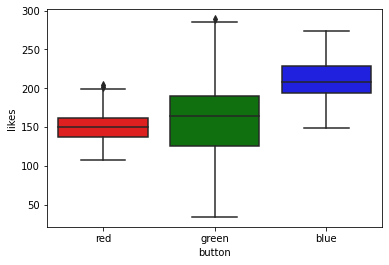

In [11]:
#боксплот. pallete задает цвет графиков

sns.boxplot(x="button", y="likes", data=post_likes, palette=["r", "g", "b"])

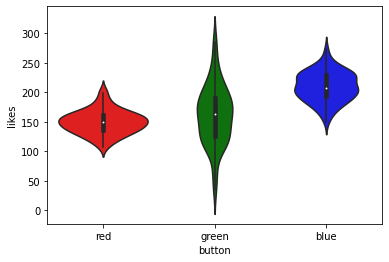

In [8]:
#скрипичный график

sns.violinplot(x="button", y="likes", data=post_likes, palette=["r", "g", "b"])

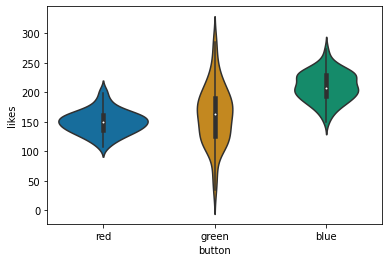

In [9]:
#для студентов с цветовой слепотой

sns.violinplot(x="button", y="likes", data=post_likes, palette="colorblind")

Три способа посчитать однофакторный ANOVA:

### 1 способ. Через SCIPY

In [19]:
#через scipy

red = post_likes.query("button == 'red'").likes
green = post_likes.query("button == 'green'").likes
blue = post_likes.query("button == 'blue'").likes

In [13]:
post_likes.query("button == 'red'").likes

0     160
1     150
2     150
3     150
4     187
     ... 
95    170
96    164
97    125
98    152
99    126
Name: likes, Length: 100, dtype: int64

In [14]:
ss.f_oneway(red, green, blue)

F_onewayResult(statistic=85.99631112614011, pvalue=3.4370045810218544e-30)

### 2 СПОСОБ ИСПОЛЬЗУЕМ statsmodels

In [15]:
#через statsmodels

# likes - это перемернная через которую мы провереяем, а button - это независимая переменная

model = smf.ols(formula = "likes ~ button", data = post_likes).fit()
# чтобы отобразить модель/
anova_lm(model)

# button - это межгрупповая сумма квадратов, а residual - это внутригрупповая

#PR(>F) - это p-value

,df,sum_sq,mean_sq,F,PR(>F)
button,2.0,201960.286667,100980.143333,85.996311,3.437005e-30
Residual,297.0,348748.710000,1174.238081,NaN,NaN


In [19]:
348748.710000 / 297.0

1174.238080808081

### 3 СПОСОБ. Используем pingouin

In [16]:
#через pingouin

#between - независимые переменные. dv - зависимые

pg.anova(data=post_likes, dv="likes", between="button")

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,297,85.996311,3.437005e-30,0.366728


In [17]:
pg.anova(data=post_likes, dv="likes", between="button", detailed = True)

,Source,SS,DF,MS,F,p-unc,np2
0,button,201960.286667,2,100980.143333,85.996311,3.437005e-30,0.366728
1,Within,348748.710000,297,1174.238081,NaN,NaN,NaN


### ГРАФИКИ ДЛЯ ТОГО, ЧТОБЫ ОПРЕДЕЛИТЬ КАКИЕ ГРУППЫ МЕЖДУ СОБОЙ ОТЛИЧАЮТСЯ

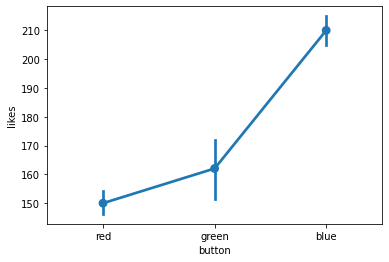

In [23]:
#средние с доверительными интервалами

sns.pointplot(x="button", y="likes", data=post_likes)

### Тестируем нормальность:

In [20]:
#через scipy .Метод Шапиро

print(ss.shapiro(red))
print(ss.shapiro(blue))
print(ss.shapiro(green))

ShapiroResult(statistic=0.988104522228241, pvalue=0.515945315361023)
ShapiroResult(statistic=0.9937936663627625, pvalue=0.9309920072555542)
ShapiroResult(statistic=0.9887180328369141, pvalue=0.5625539422035217)


In [21]:
#другой вариант. Краскала Уоллеса. Тест на нормальность, более удобный

print(ss.normaltest(red))
print(ss.normaltest(blue))
print(ss.normaltest(green))

NormaltestResult(statistic=1.8343585907539965, pvalue=0.3996447324611219)
NormaltestResult(statistic=0.4606964500747045, pvalue=0.7942569741771747)
NormaltestResult(statistic=0.6727062715909409, pvalue=0.7143707913703767)


In [22]:
#через pingouin

pg.normality(data=post_likes, dv="likes", group="button", method="normaltest")

,W,pval,normal
red,1.834359,0.399645,True
green,0.672706,0.714371,True
blue,0.460696,0.794257,True


Можно квантиль-квантиль графики, чтобы проверить нормальность:

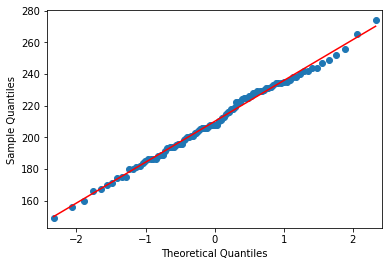

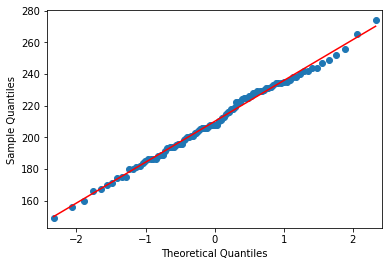

In [27]:
sm.qqplot(blue, line="r")

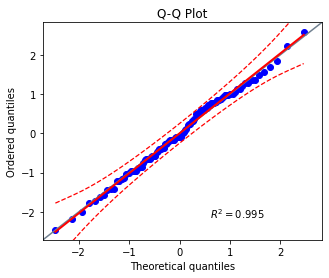

In [28]:
pg.qqplot(blue)

### Тестируем различие в дисперсиях:

In [29]:
#через scipy

ss.levene(red, green, blue)

LeveneResult(statistic=35.214282435572876, pvalue=1.8886636651084242e-14)

In [30]:
#через pingouin

pg.homoscedasticity(data=post_likes, dv="likes", group="button")

,W,pval,equal_var
levene,35.214282,1.888664e-14,False


### Мы приняли вывод, что дисперсии разные, в этом случае применяем ANOVA Уэлча

In [31]:
#anova Уэлча в pingouin

pg.welch_anova(data=post_likes, dv="likes", between="button")

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,182.958104,177.856578,1.255660e-43,0.366728


## Проблема Множественных сравнений

In [32]:
from scipy.special import comb

In [37]:
comb(10, 2)

45.0

In [38]:
1 - 0.95**45

0.9005597430129078

In [39]:
#попарные сравнения без поправки
pg.pairwise_ttests(data=post_likes, dv="likes", between="button")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,1.583,0.315609


In [40]:
2.619001e-02

0.02619001

In [43]:
#с поправкой Бонферрони
pg.pairwise_ttests(data=post_likes, dv="likes", between="button", padjust="holm")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,5.123733e-15,holm,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,2.385699e-45,holm,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,2.619001e-02,holm,1.583,0.315609


In [44]:
2.619001e-02

0.02619001

In [45]:
#тьюки

pg.pairwise_tukey(data=post_likes, dv="likes", between="button")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,blue,green,210.03,162.02,48.01,4.846108,9.906919,0.001000,1.395736
1,blue,red,210.03,149.96,60.07,4.846108,12.395514,0.001000,1.746342
2,green,red,162.02,149.96,12.06,4.846108,2.488595,0.035581,0.350606


In [46]:
#геймс-хоувелл

pg.pairwise_gameshowell(data=post_likes, dv="likes", between="button")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,blue,green,210.03,162.02,48.01,5.588343,8.591097,145.583529,0.001000,1.210357
1,blue,red,210.03,149.96,60.07,3.200454,18.769214,188.902921,0.001000,2.644301
2,green,red,162.02,149.96,12.06,5.383475,2.240189,129.889834,0.068387,0.315609


In [47]:
pairwise_tukeyhsd(post_likes.likes, post_likes.button).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


In [48]:
MultiComparison(post_likes.likes, post_likes.button).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


#### Многофакторный ANOVA

In [49]:
#грузим многофакторные данные

ads_clicks = pd.read_csv("ads_clicks.csv")

In [50]:
ads_clicks.head()

,id,ads,age_group,clicks
0,S001,classic,18-27,40
1,S002,classic,18-27,22
2,S003,classic,18-27,41
3,S004,classic,18-27,35
4,S005,classic,18-27,39


In [51]:
#через statsmodels, только главные эффекты

model_main = smf.ols("clicks ~ C(ads) + C(age_group)", data=ads_clicks).fit()
anova_lm(model_main)

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,68.810244,7.245176e-16
C(age_group),2.0,400495.163333,200247.581667,408.450696,1.950084e-112
Residual,596.0,292195.753333,490.261331,NaN,NaN


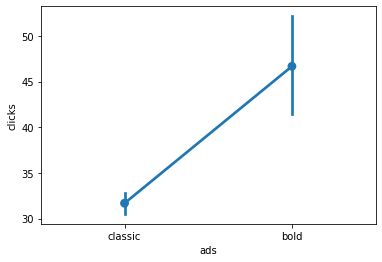

In [53]:
#первый фактор

sns.pointplot(x="ads", y="clicks", data=ads_clicks)

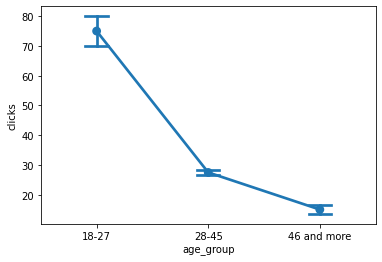

In [54]:
#второй фактор

sns.pointplot(x="age_group", y="clicks", data=ads_clicks, capsize=0.2)

In [56]:
#взаимодействие

model_interact = smf.ols("clicks ~ C(ads)*C(age_group)", data=ads_clicks).fit()
anova_lm(model_interact)

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,336.722432,6.446773e-60
C(age_group),2.0,400495.163333,200247.581667,1998.750536,1.636934e-264
C(ads):C(age_group),2.0,232685.043333,116342.521667,1161.260853,5.618312e-206
Residual,594.0,59510.710000,100.186380,NaN,NaN


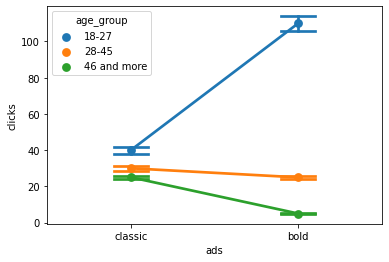

In [57]:
#взаимодействие

sns.pointplot(x="ads", y="clicks", hue="age_group", data=ads_clicks, capsize=0.2)

In [58]:
a

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.361786
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.870631
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.796333
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [59]:
#размер эффекта

pg.anova(data=ads_clicks, dv="clicks", between=["ads", "age_group"], effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.046440
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.551323
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.320315
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [68]:
#тип суммы квадратов

pg.anova(data=ads_clicks, dv="clicks", between=["ads", "age_group"], ss_type=2)

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.361786
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.870631
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.796333
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [63]:
dat_unbalanced = ads_clicks.query("id != 'S001'")

In [64]:
dat_unbalanced.head()

,id,ads,age_group,clicks
1,S002,classic,18-27,22
2,S003,classic,18-27,41
3,S004,classic,18-27,35
4,S005,classic,18-27,39
5,S006,classic,18-27,35


In [65]:
pg.anova(data=dat_unbalanced, dv="clicks", between=["ads", "age_group"], ss_type=1)

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33803.779316,1.0,33803.779316,336.840901,6.486330e-60,0.362256
1,age_group,401187.127208,2.0,200593.563604,1998.833209,2.914479e-264,0.870825
2,ads * age_group,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN


In [70]:
pg.anova(data=dat_unbalanced, dv="clicks", between=["age_group", "ads"], ss_type=3)

,Source,SS,DF,MS,F,p-unc,np2
0,age_group,399202.638264,2.0,199601.319132,1988.945896,1.048185e-263,0.870266
1,ads,33678.455412,1.0,33678.455412,335.592099,9.673077e-60,0.361399
2,age_group * ads,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN


# ПРОЕКТ ЗАДАЧИ

### Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [2]:
df_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-mahatyrov/lessons/statistics/5_task_1.csv')

In [3]:
df_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-mahatyrov/lessons/statistics/5_task_2.csv')

In [15]:
df_1


,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [7]:
df_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [13]:
pg.homoscedasticity(df_1, dv="events", group="group", method='levene', alpha=0.05)

,W,pval,equal_var
levene,2.26226,0.104133,True


### Также убедитесь, что данные распределены нормально - тем же способом, что и в прошлом уроке.

### Дополнительно: сравните  результат с qq-графиками. Какой вывод можно сделать по совокупности этих методов?

In [16]:
pg.normality(data=df_1, dv="events", group="group", method="normaltest")

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


In [5]:
df_1 = df_1.dropna()

In [10]:
df_1_a = df_1.query('group == "A"').events

In [9]:
df_1_b = df_1.query('group == "B"').events

In [11]:
df_1_c = df_1.query('group == "C"').events

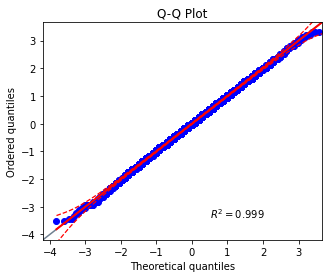

In [29]:
pg.qqplot(df_1_a.events)

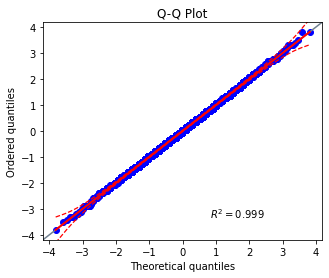

In [30]:
pg.qqplot(df_1_b.events)

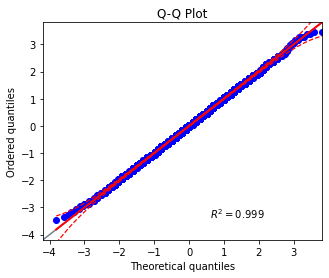

In [31]:
pg.qqplot(df_1_c.events)

### Самое время провести тест! 

In [12]:
df_1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [13]:
ss.f_oneway(df_1_a, df_1_b, df_1_c)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [14]:
pg.anova(data=df_1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


### Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 

### Дополнительно: попробуйте другие варианты поправок на множественные сравнения через pingouin. Дают ли они те же выводы, что и Тьюки?

In [15]:
pg.pairwise_tukey(data=df_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


### Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [16]:
df_1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [17]:
df_2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


In [27]:
df_2_test = df_2.query('group == "test"').events

In [28]:
df_2_control = df_2.query('group == "control"').events

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


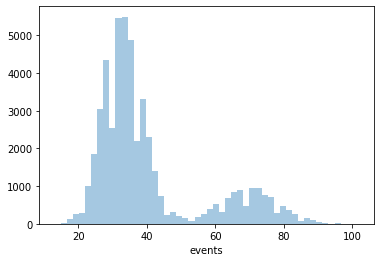

In [30]:
sns.distplot(df_2_test, kde=False)

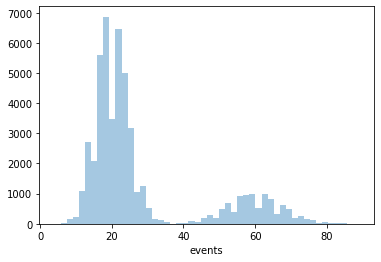

In [31]:
sns.distplot(df_2_control, kde=False)

In [41]:
df_2.groupby(['group', 'segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

<h3>
Проведите тест (через anova_lm либо pg.anova), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey:


Между какими группами были обнаружены статистически значимые различия? Выберите верные утверждения:" <h3>

In [4]:
df_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [6]:
pg.anova(data=df_2, dv="events", between=["group", "segment"], ss_type=1)

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


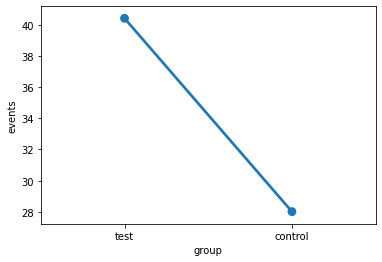

In [7]:
#первый фактор

sns.pointplot(x="group", y="events", data=df_2)

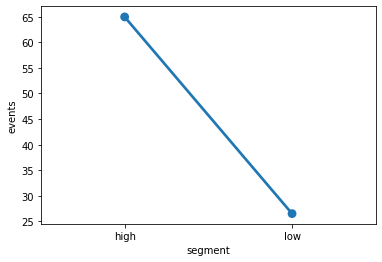

In [8]:
#второй фактор

sns.pointplot(x="segment", y="events", data=df_2)

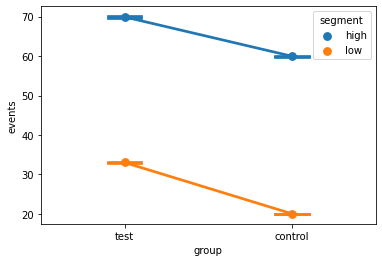

In [9]:
#взаимодействие

sns.pointplot(x="group", y="events", hue="segment", data=df_2, capsize=0.2)

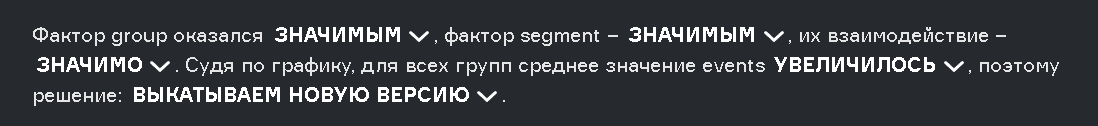